# Lorenz 63 - ODE


In [2]:
import os, sys

jaxsw_path = "/Users/eman/code_projects/jaxsw"
sys.path.append(jaxsw_path)

In [3]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import equinox as eqx
import xarray as xr

from jaxsw import L63State, Lorenz63, rhs_lorenz_63

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 63

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $(\sigma,\rho,\beta)$ are hyperparameters.

## Simulation

In [5]:
batchsize = 1_000
sigma, rho, beta = 10, 28, 2.667
key = jrandom.PRNGKey(42)
state_init, params = L63State.init_state_and_params(
    batchsize=batchsize, noise=0.01, sigma=10, rho=28, beta=2.667, key=key
)

l63_model = Lorenz63()

state_init.x.shape

(1000, 1)

## Time Stepping

### Warmup

We need to do a warmup simulation to get the dynamical system to a steady state.

In [6]:
dt = 0.005
t0 = 0.0
t1 = 10.0
dt_save = 0.01
# observe_every = 10
ts = jnp.arange(t0, t1, dt_save)
num_tsteps = len(ts)

saveat = dfx.SaveAt(
    ts=ts,
)

# Euler, Constant StepSize
solver = dfx.Tsit5()
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)

integration_fn = lambda state: dfx.diffeqsolve(
    terms=dfx.ODETerm(l63_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)

# integration
sol = jax.vmap(integration_fn)(state_init)

sol.ys.x.shape

(1000, 1000, 1)

### Simulation

In [8]:
from tqdm.autonotebook import trange
for i in trange(10):
    # integration
    state_init = eqx.tree_at(lambda x: x.x, state_init, sol.ys.x[:, -1])
    state_init = eqx.tree_at(lambda x: x.y, state_init, sol.ys.y[:, -1])
    state_init = eqx.tree_at(lambda x: x.z, state_init, sol.ys.z[:, -1])

    sol = jax.vmap(integration_fn)(state_init)

100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


In [9]:
sol.ts[0, :200].shape, sol.ys.x[:200].shape

((200,), (200, 1000))

In [10]:
ds_sol = xr.Dataset(
    {
        "x": (("realization", "time"), sol.ys.x[:, :200].squeeze()),
        "y": (("realization", "time"), sol.ys.y[:, :200].squeeze()),
        "z": (("realization", "time"), sol.ys.z[:, :200].squeeze()),
    },
    coords={
        "time": (["time"], sol.ts[0, :200].squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_sol

<xarray.Dataset>
Dimensions:  (realization: 1000, time: 200)
Coordinates:
  * time     (time) float32 0.0 0.01 0.02 0.03 0.04 ... 1.95 1.96 1.97 1.98 1.99
Dimensions without coordinates: realization
Data variables:
    x        (realization, time) float32 4.395 4.719 5.071 ... -2.268 -2.043
    y        (realization, time) float32 7.504 8.093 8.725 ... 0.131 0.04792
    z        (realization, time) float32 13.35 13.35 13.4 ... 25.17 24.5 23.85
Attributes:
    ode:      lorenz_63
    sigma:    10
    beta:     2.667
    rho:      28

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


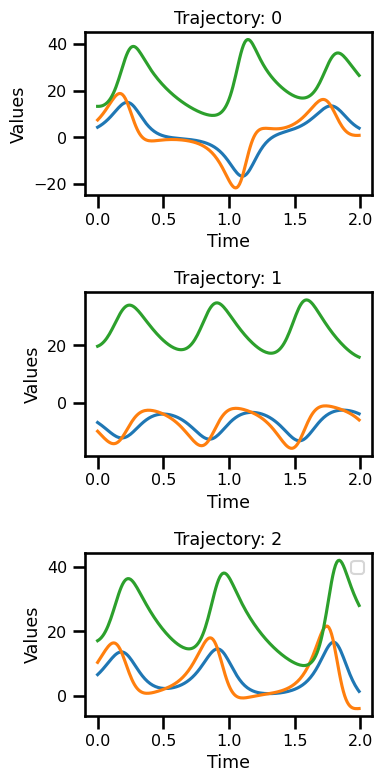

In [11]:
fig, ax = plt.subplots(nrows=3, figsize=(4, 8))

for i in range(3):
    ds_sol.x.sel(
        realization=i,
    ).plot(ax=ax[i])
    ds_sol.y.sel(
        realization=i,
    ).plot(ax=ax[i])
    ds_sol.z.sel(
        realization=i,
    ).plot(ax=ax[i])

    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Values")
    ax[i].set_title(f"Trajectory: {i}")


plt.legend()
plt.tight_layout()
plt.show()

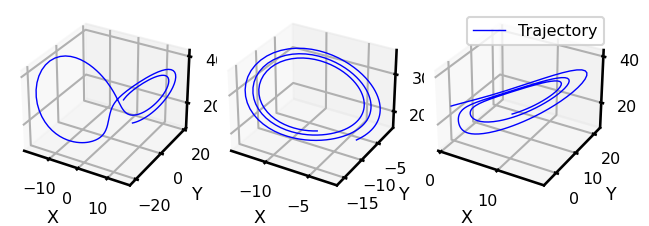

In [12]:
fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
for i in range(3):
    ax[i].plot(
        ds_sol.x.sel(
            realization=i,
        ),
        ds_sol.y.sel(
            realization=i,
        ),
        ds_sol.z.sel(
            realization=i,
        ),
        lw=1.0,
        color="blue",
        label="Trajectory",
    )
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("Z")
# ax.scatter3D(out.x[::10], out.y[::10], out.z[::10], lw=0.5, color="red", label="y")


plt.legend()
plt.tight_layout()
plt.show()

## Generating Observations


In [13]:
ds_sol = ds_sol.to_array(dim="component", name="simulation").to_dataset()
ds_sol

<xarray.Dataset>
Dimensions:     (time: 200, component: 3, realization: 1000)
Coordinates:
  * time        (time) float32 0.0 0.01 0.02 0.03 0.04 ... 1.96 1.97 1.98 1.99
  * component   (component) object 'x' 'y' 'z'
Dimensions without coordinates: realization
Data variables:
    simulation  (component, realization, time) float32 4.395 4.719 ... 23.85

### Missing Time

In [14]:
sample_step = 20
ds_sol["observations"] = xr.full_like(ds_sol.simulation, np.nan)
ds_sol["observations"].loc[..., ::sample_step] = ds_sol["simulation"].loc[
    ..., ::sample_step
]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


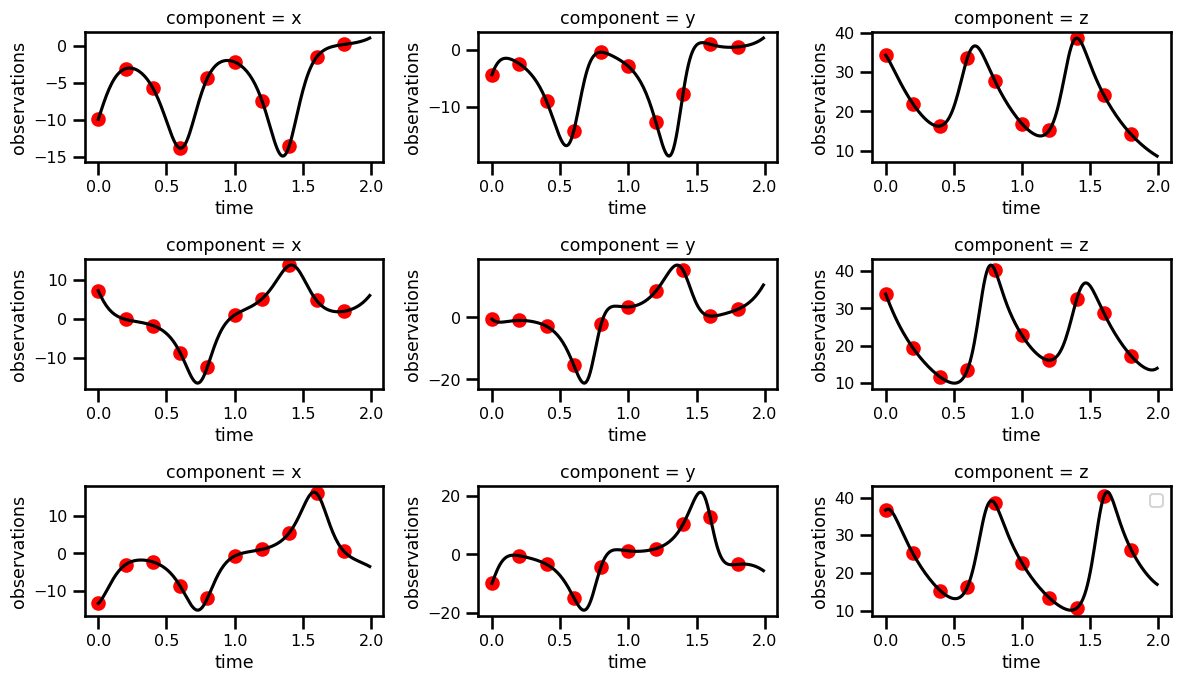

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))

for i in range(0, 3):
    ds_sol.simulation.sel(realization=i + 100, component="x").plot(
        ax=ax[i, 0], color="black"
    )
    ds_sol.observations.sel(realization=i + 100, component="x").plot.scatter(
        ax=ax[i, 0], color="red"
    )

    ds_sol.simulation.sel(realization=i + 100, component="y").plot(
        ax=ax[i, 1], color="black"
    )
    ds_sol.observations.sel(realization=i + 100, component="y").plot.scatter(
        ax=ax[i, 1], color="red"
    )

    ds_sol.simulation.sel(realization=i + 100, component="z").plot(
        ax=ax[i, 2], color="black"
    )
    ds_sol.observations.sel(realization=i + 100, component="z").plot.scatter(
        ax=ax[i, 2], color="red"
    )


plt.legend()
plt.tight_layout()
plt.show()

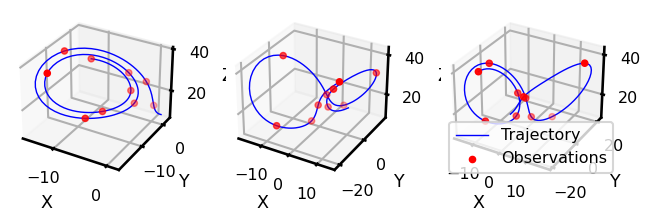

In [16]:
fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
for i in range(3):
    ax[i].plot(
        ds_sol.simulation.sel(realization=i + 100, component="x"),
        ds_sol.simulation.sel(realization=i + 100, component="y"),
        ds_sol.simulation.sel(realization=i + 100, component="z"),
        lw=1.0,
        color="blue",
        label="Trajectory",
    )
    ax[i].scatter(
        ds_sol.observations.sel(realization=i + 100, component="x"),
        ds_sol.observations.sel(realization=i + 100, component="y"),
        ds_sol.observations.sel(realization=i + 100, component="z"),
        lw=1.0,
        color="red",
        label="Observations",
    )
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("Z")


plt.legend()
plt.tight_layout()
plt.show()

### Adding Noise

In [17]:
# def add_noise(da, sigma=2**.5):
#     return da  + np.random.randn(*da.shape) * sigma

sigma = 2.0

ds_sol["observations_noise"] = ds_sol["observations"] + sigma * np.random.randn(
    *ds_sol["observations"].shape
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


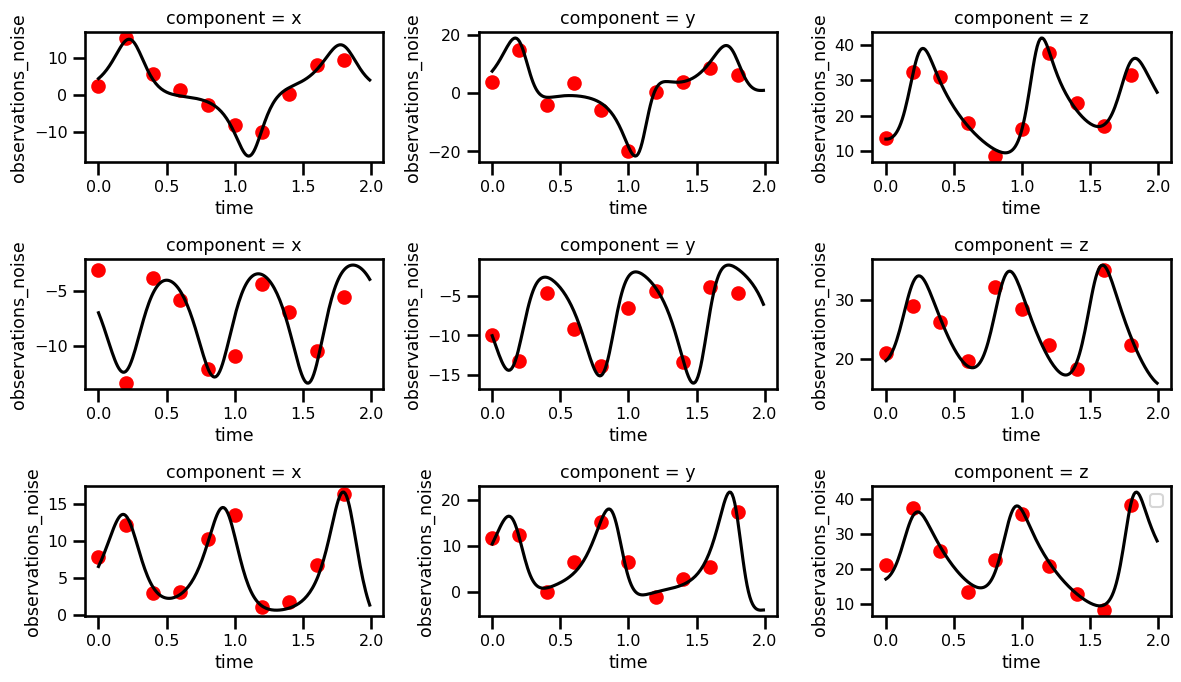

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))

for i in range(3):
    ds_sol.simulation.sel(realization=i, component="x").plot(ax=ax[i, 0], color="black")
    ds_sol.observations_noise.sel(realization=i, component="x").plot.scatter(
        ax=ax[i, 0], color="red"
    )

    ds_sol.simulation.sel(realization=i, component="y").plot(ax=ax[i, 1], color="black")
    ds_sol.observations_noise.sel(realization=i, component="y").plot.scatter(
        ax=ax[i, 1], color="red"
    )

    ds_sol.simulation.sel(realization=i, component="z").plot(ax=ax[i, 2], color="black")
    ds_sol.observations_noise.sel(realization=i, component="z").plot.scatter(
        ax=ax[i, 2], color="red"
    )


plt.legend()
plt.tight_layout()
plt.show()

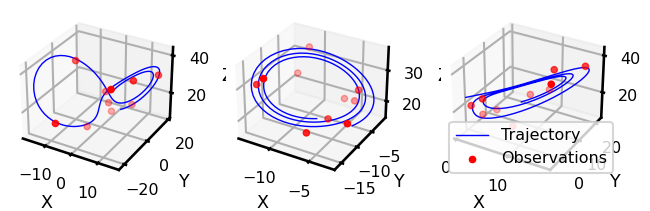

In [19]:
fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
for i in range(3):
    ax[i].plot(
        ds_sol.simulation.sel(realization=i, component="x"),
        ds_sol.simulation.sel(realization=i, component="y"),
        ds_sol.simulation.sel(realization=i, component="z"),
        lw=1.0,
        color="blue",
        label="Trajectory",
    )
    ax[i].scatter(
        ds_sol.observations_noise.sel(realization=i, component="x"),
        ds_sol.observations_noise.sel(realization=i, component="y"),
        ds_sol.observations_noise.sel(realization=i, component="z"),
        lw=1.0,
        color="red",
        label="Observations",
    )
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("Z")


plt.legend()
plt.tight_layout()
plt.show()

## Initial Interpolation

In [20]:
import scipy
from tqdm.autonotebook import trange

variable_name = "observations_interp"

ds_sol[variable_name] = xr.full_like(ds_sol.observations_noise, np.nan)


for i in trange(ds_sol.simulation.shape[1]):
    dataarray = ds_sol["observations_noise"].sel(realization=i)

    # interpolate nans
    dataarray = dataarray.interpolate_na(
        dim="time", method="slinear", fill_value="extrapolate"
    )

    # set
    ds_sol[variable_name].loc[:, i, :] = dataarray

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1469.51it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


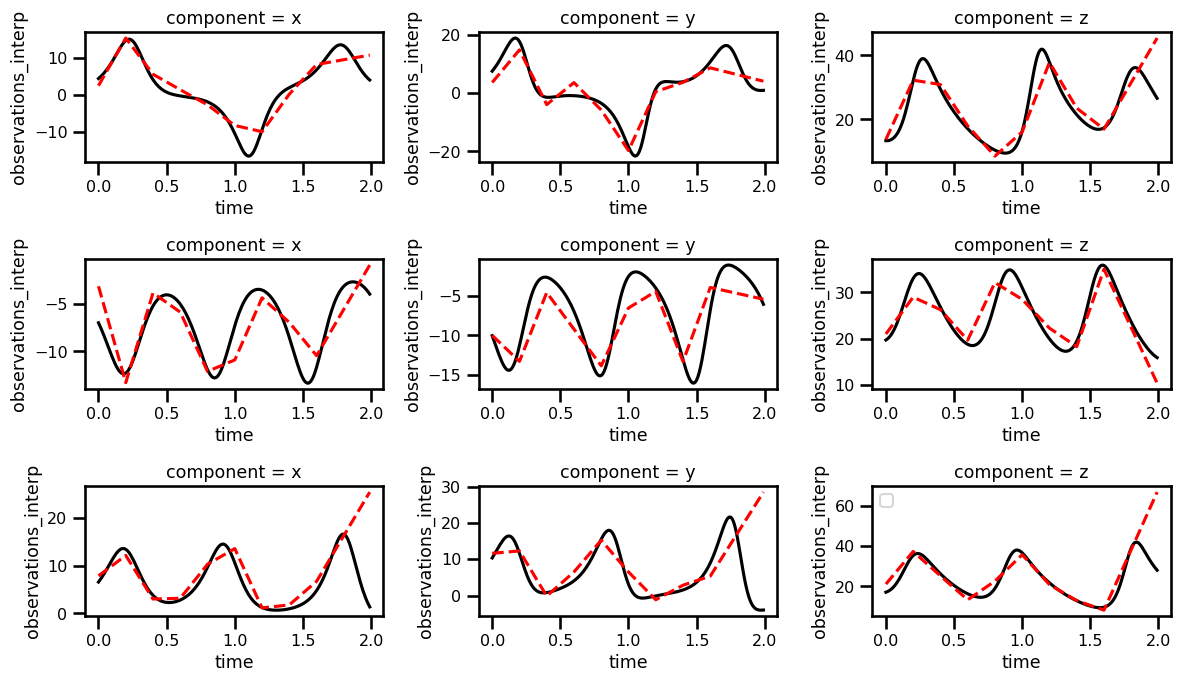

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))

for i in range(3):
    ds_sol.simulation.sel(realization=i, component="x").plot(ax=ax[i, 0], color="black")
    ds_sol.observations_interp.sel(realization=i, component="x").plot(
        ax=ax[i, 0], color="red", linestyle="--"
    )

    ds_sol.simulation.sel(realization=i, component="y").plot(ax=ax[i, 1], color="black")
    ds_sol.observations_interp.sel(realization=i, component="y").plot(
        ax=ax[i, 1], color="red", linestyle="--"
    )

    ds_sol.simulation.sel(realization=i, component="z").plot(ax=ax[i, 2], color="black")
    ds_sol.observations_interp.sel(realization=i, component="z").plot(
        ax=ax[i, 2], color="red", linestyle="--"
    )


plt.legend()
plt.tight_layout()
plt.show()

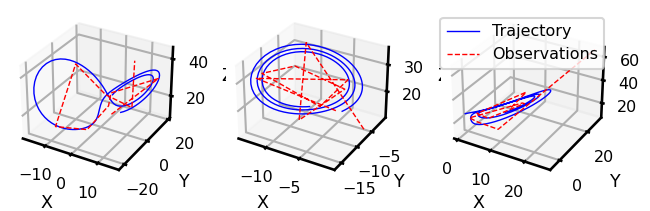

In [22]:
fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
for i in range(3):
    ax[i].plot(
        ds_sol.simulation.sel(realization=i, component="x"),
        ds_sol.simulation.sel(realization=i, component="y"),
        ds_sol.simulation.sel(realization=i, component="z"),
        lw=1.0,
        color="blue",
        label="Trajectory",
    )
    ax[i].plot(
        ds_sol.observations_interp.sel(realization=i, component="x"),
        ds_sol.observations_interp.sel(realization=i, component="y"),
        ds_sol.observations_interp.sel(realization=i, component="z"),
        lw=1.0,
        linestyle="--",
        color="red",
        label="Observations",
    )
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("Z")


plt.legend()
plt.tight_layout()
plt.show()

## Save Simulation

In [23]:
ds_sol.to_netcdf("./data/sim_l63.nc")